In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import skimage
from skimage import data, draw
from skimage import transform, util
import cv2
data_path = '../../../Documents/ISIC2018-Segementation/'

In [3]:
image_rows = 224
image_cols = 224

n_classes = 2

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, 1), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        resized_image = cv2.resize(imgs[i], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
        imgs_p[i] = resized_image.reshape(resized_image.shape + (1,))
    return imgs_p

def create_train_data():
#     train_data_path = os.path.join(data_path, 'train/')
#     images = sorted(os.listdir(train_data_path))
#     total = len(images)
#     imgs = np.ndarray((total, image_rows, image_cols, n_channel), dtype=np.uint8)

#     print('-'*30)
#     print('Creating train images...')
#     print('-'*30)
        
#     i = 0
#     for image_name in images:
#         img = cv2.imread(os.path.join(train_data_path, image_name))
# #         gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# #         resized_image = cv2.resize(gray_image, (image_cols, image_rows))
# #         resized_image = resized_image.reshape(resized_image.shape + (1,))
#         img = np.array(resized_image)
#         imgs[i] = img
#         print('Done: {0}/{1} images'.format(i, total))
#         i += 1
#     print('Loading done.')

#     np.save('../assets/imgs_train.npy', imgs)
#     print('Saving to .npy files done.')

    train_data_path = os.path.join(data_path, 'train/')
    images = sorted(os.listdir(train_data_path))
    total = len(images)
    imgs = np.ndarray((total, image_rows, image_cols, n_channel), dtype=np.uint8)

    print('-'*30)
    print('Creating train images...')
    print('-'*30)

    i = 0
    for image_name in images:
        img = cv2.imread(os.path.join(train_data_path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (image_cols, image_rows))
        img = np.array(img)
        imgs[i] = img
#         print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')
    
    np.save('../assets/imgs_train.npy', imgs)
    print('Saving to .npy files done.')

def create_train_masks_data():
#     train_masks_data_path = os.path.join(data_path, 'train_masks/')
#     images = sorted(os.listdir(train_masks_data_path))
#     total = len(images)

#     imgs = np.ndarray((total, image_rows, image_cols, 3), dtype=np.uint8)

#     i = 0
#     print('-'*30)
#     print('Creating train masks images...')
#     print('-'*30)
#     for image_name in images:
# #         print(image_name)
#         # Read RGB image
#         img = cv2.imread(os.path.join(train_masks_data_path, image_name))

#         # Convert to grayscale
#         gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         # Rescale to image_rows x image_cols size
#         resized_image = cv2.resize(gray_image, (image_cols, image_rows))
#         resized_image = resized_image.reshape(resized_image.shape + (1,))
#         img = np.array(resized_image)

#         img = np.array([img])

#         imgs[i] = img

#         print('Done: {0}/{1} images'.format(i, total))
#         i += 1
#     print('Loading done.')

#     train_masks_data_path = os.path.join(data_path, 'train_masks/')
#     images = sorted(os.listdir(train_masks_data_path))
#     total = len(images)

#     img_masks = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)

#     i = 0
#     print('-'*30)
#     print('Creating train masks images...')
#     print('-'*30)
#     for image_name in images:
#         img_mask = cv2.imread(os.path.join(train_masks_data_path, image_name), cv2.IMREAD_GRAYSCALE)
#         _, img_mask = cv2.threshold(img_mask, 127, 255, cv2.THRESH_BINARY)

#         # Rescale to image_rows x image_cols size
#         img_mask = cv2.resize(img_mask, (image_cols, image_rows))
#         img_mask = np.array(img_mask)
#         img_mask = np.array(img_mask)
#         img_masks[i] = img_mask
#         i += 1

    train_masks_data_path = os.path.join(data_path, 'train_masks/')
    images = sorted(os.listdir(train_masks_data_path))
    total = len(images)

    img_masks = np.ndarray((total, image_rows, image_cols, 2), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Creating train masks images...')
    print('-'*30)
    for image_name in images:
        img_mask = cv2.imread(os.path.join(train_masks_data_path, image_name), cv2.IMREAD_GRAYSCALE)
        _, img_mask = cv2.threshold(img_mask, 127, 255, cv2.THRESH_BINARY)

        # Rescale to image_rows x image_cols size
        img_mask = cv2.resize(img_mask, (image_cols, image_rows))
        img_mask = np.array(img_mask)
        img_mask = np.array(img_mask)
        img_masks[i] = img_mask
        i += 1


    np.save('../assets/imgs_mask_train.npy', img_masks)
    print('Saving to .npy files done.')    

def load_train_data():
    imgs_train = np.load('../assets/imgs_train.npy')
    imgs_mask_train = np.load('../assets/imgs_mask_train.npy')
    return imgs_train, imgs_mask_train

# create_train_data()
# create_train_masks_data()

In [4]:
from sklearn.model_selection import train_test_split
# from keras import backend as K
import tensorflow.keras.backend as K

img_rows = 224 
img_cols = 224

# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)a
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# def dice_coef_loss(y_true, y_pred):
#     return -dice_coef(y_true, y_pred)

# def preprocess(imgs):
#     imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, ), dtype=np.uint8)
#     for i in range(imgs.shape[0]):
#         resized_image = cv2.resize(imgs[i], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
# #         imgs_p[i] = resized_image.reshape(resized_image.shape + (1,))
#         imgs_p[i] = resized_image
#     return imgs_p


train, mask = load_train_data()
# train = preprocess(train)
# mask = preprocess(mask)

train = train.astype('float32')
mean = np.mean(train)  # mean for data centering
std = np.std(train)  # std for data normalization

train -= mean
train /= std

mask = mask.astype('float32')
mask /= 255.  # scale masks to [0, 1]

X_train, X_test, y_train, y_test = train_test_split(train, mask, test_size=0.2, random_state=42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


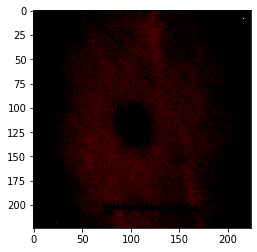

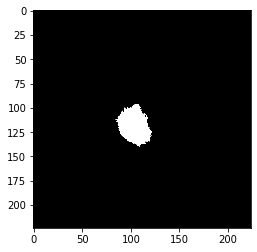

In [44]:
import random

img_index = random.randint(0, len(X_train) - 1)

# plt.imshow(cv2.cvtColor(X_train[img_index], cv2.COLOR_BGR2RGB))
plt.imshow(X_train[img_index])
plt.show()

plt.imshow(y_train[img_index], cmap='gray')
plt.show()

In [11]:
import cv2
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout

# referring from https://www.tensorflow.org/tutorials/images/segmentation
def unet_model(output_channels):
    IMG_SHAPE = (224, 224, 3)
    filepath = "../assets/mobilenetv2_model.h5"
    # Create the base model from the pre-trained model MobileNet V2
    mobilev2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
    x = mobilev2.layers[-2].output
    predictions = Dense(7, activation='softmax')(x)
    base_model = Model(inputs=mobilev2.input, outputs=predictions)
    base_model.load_weights(filepath)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = tf.keras.layers.Input(shape=IMG_SHAPE)
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels,
        kernel_size=3,
        strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# tf.keras.utils.plot_model(model, show_shapes=True)

OUTPUT_CHANNELS = 1
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='tf_unet.hdf5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    validation_steps=16,
                    epochs=80, 
                    verbose=1,
                    callbacks=callbacks_list)

Train on 2075 samples, validate on 519 samples
Epoch 1/80
2064/2075 [============================>.] - ETA: 0s - loss: 2.2242 - accuracy: 0.6794
Epoch 00001: val_accuracy improved from -inf to 0.64010, saving model to tf_unet.hdf5
2075/2075 [==============================] - 16s 8ms/sample - loss: 2.2231 - accuracy: 0.6794 - val_loss: 1.1106 - val_accuracy: 0.6401
Epoch 2/80
2064/2075 [============================>.] - ETA: 0s - loss: 1.5463 - accuracy: 0.7342
Epoch 00002: val_accuracy improved from 0.64010 to 0.66955, saving model to tf_unet.hdf5
2075/2075 [==============================] - 12s 6ms/sample - loss: 1.5462 - accuracy: 0.7342 - val_loss: 1.0001 - val_accuracy: 0.6695
Epoch 3/80
2064/2075 [============================>.] - ETA: 0s - loss: 1.1354 - accuracy: 0.7865
Epoch 00003: val_accuracy improved from 0.66955 to 0.71008, saving model to tf_unet.hdf5
2075/2075 [==============================] - 12s 6ms/sample - loss: 1.1354 - accuracy: 0.7865 - val_loss: 0.7401 - val_accu

2075/2075 [==============================] - 12s 6ms/sample - loss: 0.3855 - accuracy: 0.8862 - val_loss: 0.2487 - val_accuracy: 0.8500
Epoch 27/80
2064/2075 [============================>.] - ETA: 0s - loss: 0.3799 - accuracy: 0.8874
Epoch 00027: val_accuracy improved from 0.84998 to 0.85023, saving model to tf_unet.hdf5
2075/2075 [==============================] - 12s 6ms/sample - loss: 0.3799 - accuracy: 0.8874 - val_loss: 0.2483 - val_accuracy: 0.8502
Epoch 28/80
2064/2075 [============================>.] - ETA: 0s - loss: 0.3803 - accuracy: 0.8871
Epoch 00028: val_accuracy improved from 0.85023 to 0.85212, saving model to tf_unet.hdf5
2075/2075 [==============================] - 12s 6ms/sample - loss: 0.3807 - accuracy: 0.8870 - val_loss: 0.2449 - val_accuracy: 0.8521
Epoch 29/80
2064/2075 [============================>.] - ETA: 0s - loss: 0.3760 - accuracy: 0.8887
Epoch 00029: val_accuracy improved from 0.85212 to 0.85453, saving model to tf_unet.hdf5
2075/2075 [=================

Epoch 54/80
2064/2075 [============================>.] - ETA: 0s - loss: 0.3473 - accuracy: 0.8949
Epoch 00054: val_accuracy did not improve from 0.86292
2075/2075 [==============================] - 11s 5ms/sample - loss: 0.3471 - accuracy: 0.8949 - val_loss: 0.2261 - val_accuracy: 0.8627
Epoch 55/80
2064/2075 [============================>.] - ETA: 0s - loss: 0.3516 - accuracy: 0.8935
Epoch 00055: val_accuracy did not improve from 0.86292
2075/2075 [==============================] - 11s 5ms/sample - loss: 0.3512 - accuracy: 0.8936 - val_loss: 0.2239 - val_accuracy: 0.8627
Epoch 56/80
2064/2075 [============================>.] - ETA: 0s - loss: 0.3468 - accuracy: 0.8948
Epoch 00056: val_accuracy improved from 0.86292 to 0.86377, saving model to tf_unet.hdf5
2075/2075 [==============================] - 12s 6ms/sample - loss: 0.3485 - accuracy: 0.8943 - val_loss: 0.2225 - val_accuracy: 0.8638
Epoch 57/80
2064/2075 [============================>.] - ETA: 0s - loss: 0.3485 - accuracy: 0.89

In [ ]:
# import cv2
# import numpy as np
# from tensorflow.keras import Model
# from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, Concatenate
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
# from tensorflow.keras.layers import GaussianNoise

# def get_unet(img_rows, img_cols):
#     concat_axis = 3
    
#     inputs = Input(shape=[img_rows, img_cols, 3])
#     conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(pool4)
#     conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(conv5)

# #     up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
#     up6 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv5), conv4])
#     conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(up6)
#     conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv6)

# #     up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
#     up7 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv6), conv3])
#     conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(up7)
#     conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv7)

# #     up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
#     up8 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv7), conv2])
#     conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(up8)
#     conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv8)

# #     up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
#     up9 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv8), conv1])
#     conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(up9)
#     conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv9)

#     conv10 = Convolution2D(1, (1, 1), activation='sigmoid')(conv9)

#     model = Model(inputs=inputs, outputs=conv10)


#     return model

# model = get_unet(img_rows, img_cols)

# model.compile(optimizer=Adam(lr=1e-4), 
#               loss='binary_crossentropy', 
#               metrics=['accuracy', 
#                        tf.keras.metrics.MeanIoU(num_classes=2, name='MeanIoU')])

# checkpoint = ModelCheckpoint(filepath='unet.hdf5', 
#                              monitor='val_MeanIoU', 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode='max')

# reduce_lr = ReduceLROnPlateau(monitor='val_MeanIoU', factor=0.5, patience=2, 
#                                    verbose=1, mode='max', min_lr=1e-5)

# callbacks_list = [checkpoint, reduce_lr]

# history = model.fit(X_train[0:5],
#                     y_train[0:5],
# #                     batch_size=8,
#                     batch_size=1,
#                     validation_data=(X_test, y_test),
# #                     validation_steps=8,
#                     validation_steps=1,
#                     epochs=30, 
#                     verbose=1,
#                     callbacks=callbacks_list)

In [12]:
# print('-'*30)
# print('Loading and preprocessing test data...')
# print('-'*30)
# imgs_test, imgs_id_test = load_test_data()
# imgs_test = load_test_data()
# imgs_test = preprocess(imgs_test)

# imgs_test = imgs_test.astype('float32')
# imgs_test -= mean
# imgs_test /= std
# model = get_unet()
model = unet_model(1)
model.load_weights('tf_unet.hdf5')
imgs_mask_test = model.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


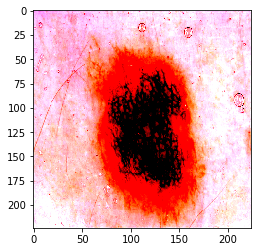

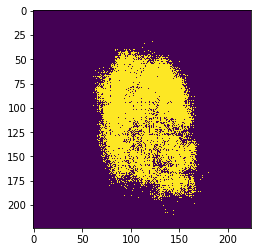

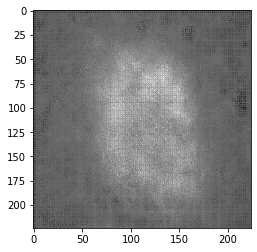

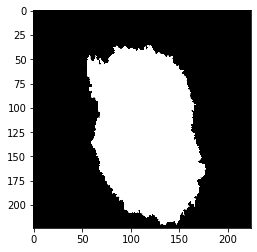

In [45]:
img_index = random.randint(0, len(X_test))

_, mask_to_show = cv2.threshold(imgs_mask_test[img_index], 0.8, 1, cv2.THRESH_BINARY)

plt.imshow(X_test[img_index])
plt.show()

plt.imshow(mask_to_show)
plt.show()

plt.imshow(imgs_mask_test[img_index].reshape(img_rows, img_cols), cmap='gray')
plt.show()

plt.imshow(y_test[img_index].reshape(img_rows, img_cols), cmap='gray')
plt.show()

# plt.imshow(imgs_mask_test)

In [49]:
# test_data_path = os.path.join(data_path, 'test/')
# images = sorted(os.listdir(test_data_path))
# total = len(images)
# raw_imgs = []
# imgs = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)

# i = 0
# print('-'*30)
# print('Creating test images...')
# print('-'*30)
# for image_name in images:
#     # Read RGB image
#     img = cv2.imread(os.path.join(test_data_path, image_name))
#     raw_imgs.append(img)
#     # Convert to grayscale
#     gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     # Rescale to image_rows x image_cols size
#     resized_image = cv2.resize(gray_image, (image_cols, image_rows))
#     resized_image = resized_image.reshape(resized_image.shape + (1,))
#     img = np.array(resized_image)
#     imgs[i] = img
#     print('Done: {0}/{1} images'.format(i, total))
#     i += 1
# print('Loading done.')

# np.save('imgs_test.npy', imgs)
# print('Saving to .npy files done.')

def create_test_data():
    test_data_path = os.path.join(data_path, 'test/')
    images = sorted(os.listdir(test_data_path))
    total = len(images)
    imgs = np.ndarray((total, image_rows, image_cols, 3), dtype=np.uint8)

    print('-'*30)
    print('Creating test images...')
    print('-'*30)

    i = 0
    for image_name in images:
        img = cv2.imread(os.path.join(test_data_path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (image_cols, image_rows))
        img = np.array(img)
        imgs[i] = img
    #         print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save('../assets/imgs_test.npy', imgs)
    print('Saving to .npy files done.')
    
create_test_data()

------------------------------
Creating test images...
------------------------------
Loading done.
Saving to .npy files done.


In [58]:
raw_imgs = np.load('../assets/imgs_test.npy')
test = raw_imgs.astype('float32')

mean = np.mean(test)  # mean for data centering
std = np.std(test)  # std for data normalization
test -= mean
test /= std

In [56]:
model = unet_model(1)
model.load_weights('tf_unet.hdf5')
prediction = model.predict(test)

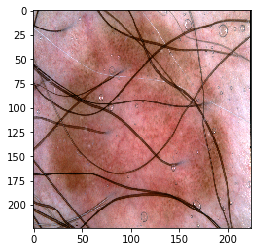

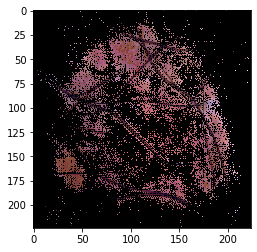

In [111]:
img_index = random.randint(0, len(test))

# plt.imshow(cv2.cvtColor(raw_imgs[img_index], cv2.COLOR_BGR2RGB))
plt.imshow(raw_imgs[img_index])
plt.show()

# plt.imshow(test[img_index].reshape(img_rows, img_cols), cmap='gray')
# plt.show()

# plt.imshow(prediction[img_index].reshape(img_rows, img_cols), cmap='gray')
# plt.show()

img = raw_imgs[img_index]
mask = cv2.inRange(cv2.cvtColor(prediction[img_index], cv2.COLOR_GRAY2RGB),
                   (0.9, 0.9, 0.9),
                   (1, 1, 1))

confidence = 0.8
_, mask_to_show = cv2.threshold(prediction[img_index], confidence, 1, cv2.THRESH_BINARY)
mask = cv2.inRange(mask_to_show,
                   (confidence),
                   (1))

# Create a blank 300x300 black image
red = np.zeros((img_rows, img_cols, 3), np.uint8)
# Fill image with red color(set each pixel to red)
red[:] = (0, 0, 50)

plt.imshow(cv2.bitwise_or(red, img, mask=mask))

In [ ]:
## mask = (prediction[img_index].reshape(img_rows, img_cols) > 9e-1)
c = cv2.cvtColor(raw_imgs[img_index], cv2.COLOR_BGR2RGB)
img= cv2.resize(img, (240, 192))

print(np.shape(img))
kk = cv2.cvtColor(prediction[img_index], cv2.COLOR_GRAY2RGB)
print(np.shape(kk))
mask = cv2.inRange(kk, (0.9, 0.9, 0.9), (1, 1, 1))

plt.imshow(cv2.bitwise_and(img, img, mask=mask))
plt.show()
plt.imshow(img)
plt.show()

In [ ]:
plt.imshow((prediction[0].reshape(img_rows, img_cols) > 0.01) & (prediction[0].reshape(img_rows, img_cols) < 0.8))
plt.show()

plt.imshow(prediction[0].reshape(img_rows, img_cols), cmap='gray')
plt.show()